<a href="https://colab.research.google.com/github/helmieresearch/helmieresearch/blob/main/Momentum_Ranking_Model_revised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install packages

In [2]:
!pip install yfinance

In [3]:
!pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.4 MB/s eta 0:00:00


In [4]:
!pip install stockstats

In [5]:
!pip install mpld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 6.2 MB/s eta 0:00:00


###Modules and settings

In [10]:
%matplotlib inline
import datetime
from datetime import date
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import mpld3
mpld3.enable_notebook()
"""
Settings
"""
portfolio_value = 155164.96
perf_last_month = 151728.55
start = "2020-01-01"
end = "2023-09-18"
ranking_day = "2023-09-15"
index_date = 'STXCAP150923.csv'
ranking_table ="ranking_table150923.csv"
portfolio = "portfolio150923.csv"
current_portfolio = "portfolio310823.csv"

# Storing today's date into a variable
today = date.today()
# Storing the specific date
trading_day = today
# Calculate percent difference since last month
perf_pct = (portfolio_value / perf_last_month) - 1
# Print performance, format as percent with two decimals.
print("{} - Last Month Result: {:.2%}".format(trading_day, perf_pct))
# Remember today's portfolio value for next month's calculation
#perf_last_month = portfolio_value

2023-09-15 - Last Month Result: 2.26%


###Import Market Data

             Close          SMA       diff
Date                                      
2023-09-15  3758.0  3809.254816 -51.254816
Exchange Name = Johannesburg Stock Exchange
PROSUS N.V.: PRX.XJSE
ANHEUSER-BUSCH INBEV SA NV: ANH.XJSE
BHP GROUP PLC: BHP.XJSE
BRITISH AMERICAN TOB PLC: BTI.XJSE
NASPERS LTD -N-: NPN.XJSE
COMPAGNIE FIN RICHEMONT: CFR.XJSE
GLENCORE PLC: GLN.XJSE
ANGLO AMERICAN PLC: AGL.XJSE
FIRSTRAND LTD: FSR.XJSE
ANGLO AMERICAN PLAT LTD: AMS.XJSE
STANDARD BANK GROUP LTD: SBK.XJSE
VODACOM GROUP LTD: VOD.XJSE
MONDI PLC: MNP.XJSE
CAPITEC BANK HLDGS LTD: CPI.XJSE
BEE - SASOL LIMITED: SOLBE1.XJSE
SANLAM LIMITED: SLM.XJSE
MTN GROUP LTD: MTN.XJSE
ANGLOGOLD ASHANTI LTD: ANG.XJSE
SASOL LIMITED: SOL.XJSE
ABSA GROUP LIMITED: ABG.XJSE
SOUTH32 LIMITED: S32.XJSE
RMB HOLDINGS LTD: RMH.XJSE
IMPALA PLATINUM HLGS LTD: IMP.XJSE
BID CORPORATION LTD: BID.XJSE
REMGRO LTD: REM.XJSE
KUMBA IRON ORE LTD: KIO.XJSE
NEDBANK GROUP LTD: NED.XJSE
SIBANYE STILLWATER LTD: SSW.XJSE
GOLD FIELDS LTD: GFI.XJSE
IN

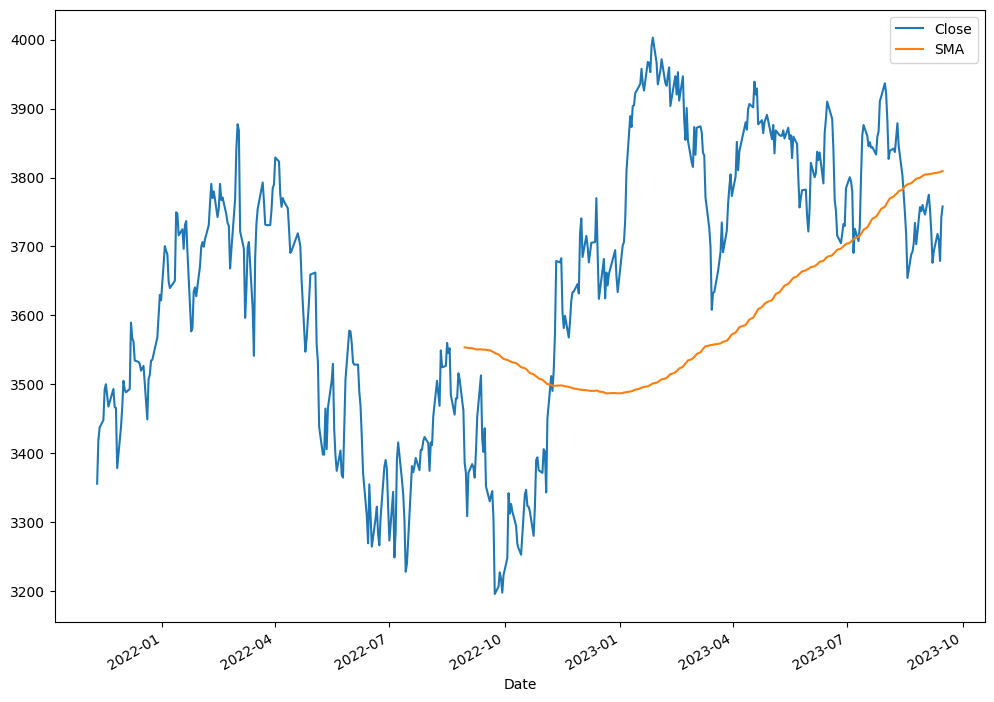

In [11]:
#Import required libraries
import pandas as pd
import json
import requests
import glob
import os
from yahooquery import Ticker
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d")
data = yf.Ticker("STXCAP.JO")
index = data.history(start=start,  end=end)
resetindex = index.reset_index(inplace = True)

index['Date'] = pd.to_datetime(index['Date']).dt.strftime('%Y-%m-%d')

index = index.drop(columns=(['Open', 'High','Low','Volume','Dividends','Stock Splits']))

index.set_index("Date", inplace=True)

index.to_csv(index_date)
STX = pd.read_csv(index_date,index_col='Date', parse_dates=['Date'])
STX['SMA'] = STX['Close'].rolling(200).mean()
STX.plot()
STX['diff'] = STX['Close'] - STX['SMA']
print(STX.tail(1))


params = {'access_key': 'e52cf3b93696352e880916f8c8adbf0c',
          'limit': 350}
api_result = requests.get('http://api.marketstack.com/v1/exchanges/XJSE/tickers', params)
api_response = api_result.json()
print(f"Exchange Name = {api_response['data']['name']}")
for ticker in api_response['data']['tickers']:
  print(f"{ticker['name']}: {ticker['symbol']}")


# Serializing json
json_object = json.dumps(api_response, indent=4)
# Writing to sample.json
with open("jse.json", "w") as outfile:
    outfile.write(json_object)

# Opening JSON file
with open('jse.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
df1 = pd.json_normalize(json_object["data"]["tickers"])

# dropping null value columns to avoid errors
# new data frame with split value columns
new = df1["symbol"].str.split(".", n = 1, expand = True)
# making separate first name column from new data frame
df1["ticker"]= new[0]
# Dropping old Name columns
df1.drop(columns =["has_intraday","has_eod"], inplace = True)
new.columns = new.columns.astype(str)
new.columns.values[1] = "tickers"
new['0'] + '.' + new['tickers']
new.replace("XJSE", "JO", inplace=True)

result = pd.concat([df1, new], axis=1, join='inner')
df2=result['0'] + '.' + result['tickers']
final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)
#Dropping old Name columns
final.drop(columns =["name", "symbol","ticker"], inplace = True)
# Converting a specific Dataframe
# column to list using Series.tolist()
xjse = final["tickers"].tolist()
print("Converting tickers to list...")
print("Output dataframe..." )
print("Writing csv file..." )
print("Saving JSE data to disc...")
print("Saving csv files for each stock to disc...")
symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start= start, end=end, interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)


#Convert dataframe to csv and save to disc
final.to_csv("tickers.csv")
data.to_csv("jse_stocks.csv")

resetindex = data.reset_index(inplace = True)

for i, g in data.groupby('symbol'):
    g.to_csv('/content/Stocks/{}.csv'.format(i), header=True, index_label=False)

# merging the files
joined_files = os.path.join("/content/Stocks/", "*.csv")

# A list of all joined files is returned
joined_list = glob.glob(joined_files)

# Finally, the files are joined
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

# new dataframe with different column order
df_new = df.iloc[:, [1, 2, 3, 4, 5, 6, 0]]

Tickers = df_new["symbol"].tolist()
mylist = list(dict.fromkeys(Tickers))
df = pd.DataFrame (mylist, columns = ['tickers'])
df.to_csv("/content/tickers.csv")

#Change date format to Year-Month-Day
df_new['date'] =  pd.to_datetime(df_new['date']).dt.strftime('%Y-%m-%d')

df_new.set_index('date', inplace=True)

for i, g in df_new.groupby('symbol'):
    g.to_csv('/content/Stocks_final3/{}.csv'.format(i), header=True, index_label=False)

symbols = xjse
tickers = Ticker(symbols, asynchronous=True)
data = tickers.history(start=start, end=end, interval='1d')
data= data.drop(['adjclose','dividends','splits'],axis=1)

resetindex = data.reset_index(inplace = True)

# new dataframe with different column order
df_new = data.iloc[:, [1, 2, 3, 4, 5, 6, 0]]

Tickers = df_new["symbol"].tolist()
mylist = list(dict.fromkeys(Tickers))
df = pd.DataFrame (mylist, columns = ['tickers'])
df.columns = df.iloc[1]

df.to_csv("/content/Stocks_final3/tickers.csv")


csv_folder = Path('/content/Stocks_final3')

for file in csv_folder.glob('*.JO.csv'): #create iteratable & iterate on it.
    mydata = pd.read_csv(file)
    mydata.reset_index(inplace = True)
    mydata = mydata.rename(columns={'index': 'date'}, index=None)
    mydata['date'] =  pd.to_datetime(mydata['date']).dt.strftime('%Y-%m-%d')
    mydata.set_index('date', inplace=True)
    df =mydata[["open","high","low","close","volume"]]
    no_outlier_prices = df[(np.abs(stats.zscore(df)) <3).all(axis=1)]
    new_file_name = file.parent.joinpath(f"{file.stem}.csv")
    no_outlier_prices.to_csv(new_file_name) #, index=None, encoding='utf-8-sig', decimal=',')

###Indicators

In [12]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from pathlib import Path
import pandas as pd
import stockstats
from stockstats import StockDataFrame as sdf
import glob

plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.ioff()

tickers = pd.read_csv('/content/Stocks_final3/tickers.csv', header=None)[1].tolist()
stocks = (
    (pd.concat(
        [pd.read_csv(f"/content/Stocks_final3/{ticker}.csv",parse_dates=None, index_col=0)[
        'close'].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)
stocks = stocks.loc[:,~stocks.columns.duplicated()]

from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

momentums = stocks.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)

result = momentums.sort_values(by =ranking_day, axis = 1, ascending =False)
result.reset_index(inplace=True)
res=result[~(result['date'] < ranking_day)].dropna(axis=1)

mes = res.reindex(columns = res.columns.tolist()
                                  + ['empty'])

df = mes.set_index(['empty']).stack().reset_index(name='index').rename(columns={'level_2':'date'})

df.columns = df.iloc[0]

df.index = list(df.index)

df.columns.values[0] = "empty"
df.columns.values[1] = "symbol"
df.columns.values[2] = "momentum_score"

df=df.drop(['empty'], axis=1)

finalframe=df.drop(index=0)

finalframe['momentum_score'] =finalframe['momentum_score'].astype(float)

finalframe['rank']=finalframe['momentum_score'].rank(ascending=False)

finalframe['momentum_score'] =finalframe['momentum_score'].astype(float)

#finalframe.style.format({'momentum_score':"{:.2f}"})

Mylist = finalframe["symbol"].tolist()

finalframe.set_index('symbol',inplace=True)

final = pd.concat([df1, df2], axis=1, join='inner')
final.columns.values[3] = "tickers"
final.columns = final.columns.astype(str)

final.set_index('tickers', inplace=True)
Yes = final.reindex(Mylist)

rt = pd.concat([finalframe, Yes], axis=1, join='inner')

rt = rt.iloc[:, [2, 3, 4, 0, 1]]

#rt.style.format({'momentum_score':"{:.2f}"})

# get names of indexes for which column "momentum_score" has value > 40%
index_names = rt[(rt['momentum_score'] < 0.001)].index

# drop these given row indexes from dataFrame
rt.drop(index_names, inplace = True)

rt.reset_index(inplace=True)

lowranked = rt [( rt ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
rt.drop( lowranked, inplace = True)

My_final_list = rt["index"].tolist()

rt.set_index('index',inplace=True)

rt.to_csv(ranking_table)
final_table_columns = My_final_list
final_table =stocks.drop(columns=[col for col in stocks if col not in final_table_columns])

for column in final_table.columns:
    final_table[column].to_csv('/content/momentum_tickers/' + column + '.csv')

vola_table = Path('/content/momentum_tickers')

for file in vola_table.glob('*.JO.csv'): #create iteratable & iterate on it.
    vola_df = pd.read_csv(file)
    vola_df.columns.values[1] = "close"
    vola_df["20d_vol"] = vola_df["close"].pct_change().rolling(20).std()
    #vola_df = sdf.retype(vola_df)['close_90_roc']
    #vola_df = pd.DataFrame(vola_df)
    vola_df['date'] =  pd.to_datetime(vola_df['date']).dt.strftime('%Y-%m-%d')
    vola_df.set_index('date', inplace=True)
    stockstats_df = sdf.retype(vola_df)['close_90_roc']
    df = pd.DataFrame(stockstats_df)
    vola_file_name= file.parent.joinpath(f"/content/ranking_table/{file.stem}.csv")
    vola_df.to_csv(vola_file_name) #, index=None, encoding='utf-8-sig', decimal=',')

vola_table1 = Path('/content/ranking_table')

for file in vola_table1.glob('*.JO.csv'): #create iteratable & iterate on it.
    vola_df1 = pd.read_csv(file).tail(1)

    vola_df1['date'] =  pd.to_datetime(vola_df1['date']).dt.strftime('%Y-%m-%d')

    vola_df1.set_index('date', inplace=True)

    vola_file_name1= file.parent.joinpath(f"/content/momentum_stocks/{file.stem}.csv")

    vola_df1.to_csv(vola_file_name1)


# set search path and glob for files
# here we want to look for csv files in the input directory
path = '/content/'
files = glob.glob(path + '/momentum_stocks/*.csv')

# create empty list to store dataframes
li = []

# loop through list of files and read each one into a dataframe and append to list
for f in files:
    # get filename
    stock = os.path.basename(f)
    # read in csv
    temp_df = pd.read_csv(f)
    # create new column with filename
    temp_df['ticker'] = stock
    # data cleaning to remove the .csv
    temp_df['ticker'] = temp_df['ticker'].replace('.csv', '', regex=True)
    # append df to list
    li.append(temp_df)
    #print(f'Successfully created dataframe for {stock} with shape {temp_df.shape}')

# concatenate our list of dataframes into one!
df = pd.concat(li)

ranking_list =df.set_index('ticker').reindex(My_final_list).reset_index()

inv_vol = 1 / ranking_list["20d_vol"]
sum_inv_vol=inv_vol.sum()
vol_targets = inv_vol / sum_inv_vol
ranking_list["weight"] = vol_targets

ranking_list.set_index('ticker', inplace=True)

final_list = pd.concat([rt,ranking_list], axis=1, join='inner')

stockprice = final_list["close"] / 100
pos_weight = portfolio_value * final_list["weight"]
final_list["units"] = pos_weight / stockprice
final_list["ZAR"] = stockprice * final_list["units"]


sma = Path('/content/ranking_table')

for file in sma.glob('*.JO.csv'): #create iteratable & iterate on it.
    sma = pd.read_csv(file)
    sma['date'] =  pd.to_datetime(sma['date']).dt.strftime('%Y-%m-%d')
    sma.set_index('date', inplace=True)

    '''Function'''

    sma['100d_sma'] = sma['close'].rolling(100).mean()

    #sma['index_sma']=index['Close'].rolling(200).mean()

    #sma['trend'] = np.where(sma['close'] > sma['100d_sma'], True, False)

    sma['index'] = index['Close']

    sma['index_sma']=index['Close'].rolling(200).mean()

    sma['trend'] = np.where(sma['close'] > sma['100d_sma'], True, False)

    sma['index_trend']= np.where(sma['index'] > sma['index_sma'], True, False)

    sma_file_name= file.parent.joinpath(f"/content/sma_data/{file.stem}.csv")

    sma.to_csv(sma_file_name)

buy_table = Path('/content/sma_data')

for file in buy_table.glob('*.JO.csv'): #create iteratable & iterate on it.
    buy_list_df = pd.read_csv(file).tail(1)

    buytable = file.parent.joinpath(f"/content/buy_list/{file.stem}.csv")

    buy_list_df.to_csv(buytable)

###Initial Portfolio and Ranking Table

In [65]:
import pandas as pd
import glob

# set search path and glob for files
# here we want to look for csv files in the input directory
path1 = '/content/'
files1 = glob.glob(path1 + '/buy_list/*.csv')

# create empty list to store dataframes
li1 = []

# loop through list of files and read each one into a dataframe and append to list
for f1 in files1:
    # get filename
    stock1 = os.path.basename(f1)
    # read in csv
    temp_df1 = pd.read_csv(f1)
    # create new column with filename
    temp_df1['ticker'] = stock1
    # data cleaning to remove the .csv
    temp_df1['ticker'] = temp_df1['ticker'].replace('.csv', '', regex=True)
    # append df to list
    li1.append(temp_df1)
    #print(f'Successfully created dataframe for {stock1} with shape {temp_df1.shape}')

# concatenate our list of dataframes into one!
Buy = pd.concat(li1)

buying_list = Buy.set_index('ticker').reindex(My_final_list)#.reset_index()

final_buy_list = pd.concat([final_list, buying_list], axis=1, join='inner')

#define list of columns range
cols = [x for x in range(final_buy_list.shape[1])]

#remove second column in DataFrame
cols.remove(12)
cols.remove(13)
cols.remove(14)
cols.remove(15)
cols.remove(16)#view resulting DataFrame
final_buy_list2 =final_buy_list.iloc[:, cols]
final_buy_list2.info()

final_buy_list2 = final_buy_list2.loc[final_buy_list2.trend, :]

index_names1 = final_buy_list2[(final_buy_list2['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
final_buy_list2.drop(index_names1, inplace = True)
final_buy_list2.to_csv(portfolio)
#final_buy_list2
'''
final_buy_list2.ticker = final_buy_list2.ticker+ '.JO'
Tickers = final_buy_list2["ticker"].tolist()
sector_list=[]

for tik in Tickers:
    ticker=yf.Ticker(tik)
    sector=ticker.info['sector']
    sector_list.append(sector)

final_buy_list2['sector'] = sector_list
'''
rp_units= final_buy_list2["units"].sum()
rp_weights = final_buy_list2["weight"].sum()
rp_holdings_value= final_buy_list2["ZAR"].sum()
cash_holdings_rp = portfolio_value - rp_holdings_value

print(f"FRP total units = {rp_units}")
print(f"FRP total units = {rp_weights}")
print(f"FRP holdings value = {rp_holdings_value}")
print(f"RP cash value = {cash_holdings_rp}")
pct_cash_rp = cash_holdings_rp / portfolio_value

final_buy_list2

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, TRU.JO to ORN.JO
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            70 non-null     object 
 1   symbol          70 non-null     object 
 2   ticker          70 non-null     object 
 3   momentum_score  70 non-null     float64
 4   rank            70 non-null     float64
 5   date            70 non-null     object 
 6   close           70 non-null     float64
 7   20d_vol         70 non-null     float64
 8   close_90_roc    69 non-null     float64
 9   weight          70 non-null     float64
 10  units           70 non-null     float64
 11  ZAR             70 non-null     float64
 12  100d_sma        68 non-null     float64
 13  index           70 non-null     float64
 14  index_sma       70 non-null     float64
 15  trend           70 non-null     bool   
 16  index_trend     70 non-null     bool   
dtypes: bool(2), float64(11), object(4

,name,symbol,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
SDO.JO,STADIO HOLDINGS LIMITED,SDO.XJSE,SDO,1.465796,3.0,2023-09-15,496.0,0.023295,10.961969,0.011398,356.552255,1768.499187,470.660000,3758.0,3809.254816,True,False
FFB.JO,FORTRESS REIT LTD B,FFB.XJSE,FFB,1.353989,4.0,2023-09-15,600.0,0.019485,11.111111,0.013626,352.385349,2114.312092,528.360000,3758.0,3809.254816,True,False
MPT.JO,MPACT LIMITED,MPT.XJSE,MPT,1.207229,7.0,2023-09-15,2986.0,0.017161,11.626168,0.015472,80.396505,2400.639627,2730.400000,3758.0,3809.254816,True,False
ABG.JO,ABSA GROUP LIMITED,ABG.XJSE,ABG,1.196816,8.0,2023-09-15,17199.0,0.015683,6.101172,0.016929,15.273359,2626.865039,17182.530000,3758.0,3809.254816,True,False
RDF.JO,REDEFINE PROPERTIES LTD,RDF.XJSE,RDF,0.949661,9.0,2023-09-15,370.0,0.014497,6.321839,0.018315,768.051728,2841.791393,345.390000,3758.0,3809.254816,True,False
SPG.JO,SUPER GROUP LTD,SPG.XJSE,SPG,0.937889,10.0,2023-09-15,3317.0,0.016017,13.518138,0.016576,77.538890,2571.964978,3259.570000,3758.0,3809.254816,True,False
NPK.JO,NAMPAK LTD,NPK.XJSE,NPK,0.859912,12.0,2023-09-15,23300.0,0.068610,13.658537,0.003870,2.577003,600.441711,20390.753477,3758.0,3809.254816,True,False
SYG.JO,SYGNIA LIMITED,SYG.XJSE,SYG,0.621928,14.0,2023-09-15,1850.0,0.019005,6.998265,0.013970,117.173397,2167.707850,1743.720000,3758.0,3809.254816,True,False
CAT.JO,CAXTON CTP PUBLISH PRINT,CAT.XJSE,CAT,0.592905,15.0,2023-09-15,1077.0,0.012722,12.656904,0.020869,300.668710,3238.202010,995.460000,3758.0,3809.254816,True,False
VKE.JO,VUKILE PROPERTY FUND LTD,VKE.XJSE,VKE,0.569650,16.0,2023-09-15,1342.0,0.010404,11.833333,0.025519,295.059310,3959.695941,1280.090000,3758.0,3809.254816,True,False


###List to Liquidate current positions

In [66]:

sell_list = final_buy_list [~final_buy_list
 ["trend"]]
#sell_list.info()
dqs = sell_list ["ticker"].tolist()
cpf=pd.read_csv(current_portfolio)
#sell_list
liquidate = cpf.loc[cpf['ticker'].isin (dqs)].reset_index (drop=True)

newpf = cpf[~cpf['ticker'].isin(liquidate['ticker'])]
dfnew = newpf[~newpf['ticker'].isin(final_buy_list2['ticker'])]

remove = dfnew ["ticker"].tolist()
now = newpf[~newpf['ticker'].isin(dfnew['ticker'])]
now.set_index("ticker", inplace=True)
rebalance = now ["symbol"].tolist()

print(f"Liquidate disqualified stocks = {liquidate['name']}")
print(f"Liquidate stocks not in ranking table= {dfnew['name']}")
print(f"Portfolio after liquidation= {now['name']}")

Liquidate disqualified stocks = 0     QUANTUM FOODS HLDGS LTD
1          MOTUS HOLDINGS LTD
2                INVESTEC LTD
3    CORONATION FUND MNGRS LD
4         FORTRESS REIT LTD A
5               CASHBUILD LTD
Name: name, dtype: object
Liquidate stocks not in ranking table= 0        TELEMASTER HOLDINGS LTD
6                  CLIENTELE LTD
7         MOMENTUM MET HLDGS LTD
15             MTN ZAKHELE FUTHI
17          SEPHAKU HOLDINGS LTD
20                   TRENCOR LTD
21    SAFARI INVESTMENTS RSA LTD
Name: name, dtype: object
Portfolio after liquidation= ticker
SPG               SUPER GROUP LTD
ABG            ABSA GROUP LIMITED
ART         ARGENT INDUSTRIAL LTD
INP                  INVESTEC PLC
VKE      VUKILE PROPERTY FUND LTD
MPT                 MPACT LIMITED
SYG                SYGNIA LIMITED
SOL                 SASOL LIMITED
CAT      CAXTON CTP PUBLISH PRINT
LHC    LIFE HEALTHC GRP HLDGS LTD
RDF       REDEFINE PROPERTIES LTD
Name: name, dtype: object


In [67]:
cpf

,Unnamed: 0,name,symbol,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
0,TLM.JO,TELEMASTER HOLDINGS LTD,TLM.XJSE,TLM,286.698141,1.0,2023-08-31,101.0,22.151199,13.483146,0.000012,1.918853,1.938042,80.2795,3760.0,3811.437593,True,False
1,SPG.JO,SUPER GROUP LTD,SPG.XJSE,SPG,1.226850,3.0,2023-08-31,3407.0,0.015813,7.782347,0.017446,79.685598,2714.888324,3244.7300,3760.0,3811.437593,True,False
2,QFH.JO,QUANTUM FOODS HLDGS LTD,QFH.XJSE,QFH,1.020119,5.0,2023-08-31,485.0,0.017802,10.227273,0.015497,497.216329,2411.499198,462.1000,3760.0,3811.437593,True,False
3,ABG.JO,ABSA GROUP LIMITED,ABG.XJSE,ABG,0.903286,8.0,2023-08-31,18229.0,0.016107,3.662212,0.017127,14.620752,2665.216900,17216.5200,3760.0,3811.437593,True,False
4,MTH.JO,MOTUS HOLDINGS LTD,MTH.XJSE,MTH,0.896763,9.0,2023-08-31,10145.0,0.018976,5.435460,0.014538,22.299792,2262.313930,9764.7800,3760.0,3811.437593,True,False
5,ART.JO,ARGENT INDUSTRIAL LTD,ART.XJSE,ART,0.781111,12.0,2023-08-31,1575.0,0.015695,8.620690,0.017577,173.664493,2735.215769,1535.3300,3760.0,3811.437593,True,False
6,CLI.JO,CLIENTELE LTD,CLI.XJSE,CLI,0.777745,13.0,2023-08-31,1155.0,0.018520,10.104862,0.014896,200.690098,2317.970635,1085.4300,3760.0,3811.437593,True,False
7,MTM.JO,MOMENTUM MET HLDGS LTD,MTM.XJSE,MTM,0.730464,14.0,2023-08-31,2013.0,0.017265,12.332589,0.015979,123.524695,2486.552118,1831.7100,3760.0,3811.437593,True,False
8,INL.JO,INVESTEC LTD,INL.XJSE,INL,0.728006,15.0,2023-08-31,11084.0,0.015752,12.779813,0.017514,24.588412,2725.379611,10597.1700,3760.0,3811.437593,True,False
9,CML.JO,CORONATION FUND MNGRS LD,CML.XJSE,CML,0.688247,16.0,2023-08-31,3201.0,0.009446,10.531768,0.029205,141.977928,4544.713469,3171.3800,3760.0,3811.437593,True,False


###Update Ranking Table

In [68]:
portfolio_value2 = 156560.00

final_weights = final_buy_list
final_weights.set_index('rank').reset_index()
final_w = [x for x in range(final_weights.shape[1])]

final_w.remove(12)
final_w.remove(13)
final_w.remove(14)
final_w.remove(15)
final_w.remove(16)
final_weights2=final_weights.iloc[:, cols]
inv_vol2 = 1 / final_weights2["20d_vol"]
sum_inv_vol2 =inv_vol2.sum()
vol_targets2 = inv_vol2 / sum_inv_vol2
final_weights2["weight"] = vol_targets2

final_weights2.set_index('symbol', inplace=True)

stockprice2 = final_weights2["close"] / 100
pos_weight2 = portfolio_value2 * final_weights2["weight"]
final_weights2["units"] = pos_weight2 / stockprice2
final_weights2["ZAR"] = stockprice2 * final_weights2["units"]
final_weights2.to_csv(ranking_table)
final_weights2

<ipython-input-68-dcf7c52c0883>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2["weight"] = vol_targets2
<ipython-input-68-dcf7c52c0883>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2["units"] = pos_weight2 / stockprice2
<ipython-input-68-dcf7c52c0883>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,name,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
symbol,,,,,,,,,,,,,,,,
TRU.XJSE,TRUWORTHS INT LTD,TRU,3.739737,1.0,2023-09-15,7350.0,0.014633,48.665049,0.018144,38.647213,2840.570147,6009.41,3758.0,3809.254816,True,False
ADH.XJSE,ADVTECH LTD,ADH,1.495643,2.0,2023-09-15,2150.0,0.015216,19.179601,0.017448,127.055929,2731.702469,1874.01,3758.0,3809.254816,True,False
SDO.XJSE,STADIO HOLDINGS LIMITED,SDO,1.465796,3.0,2023-09-15,496.0,0.023295,10.961969,0.011398,359.757906,1784.399214,470.66,3758.0,3809.254816,True,False
FFB.XJSE,FORTRESS REIT LTD B,FFB,1.353989,4.0,2023-09-15,600.0,0.019485,11.111111,0.013626,355.553536,2133.321216,528.36,3758.0,3809.254816,True,False
KST.XJSE,PSG KONSULT LIMITED,KST,1.319769,5.0,2023-09-15,1357.0,0.014186,9.435484,0.018715,215.920786,2930.045066,NaN,3758.0,3809.254816,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NPN.XJSE,NASPERS LTD -N-,NPN,0.084266,66.0,2023-09-15,323525.0,0.016229,2.884683,0.016360,0.791681,2561.284652,324696.91,3758.0,3809.254816,False,False
BAW.XJSE,BARLOWORLD LTD,BAW,0.074918,67.0,2023-09-15,8262.0,0.014606,-5.306590,0.018178,34.445396,2845.878592,8549.12,3758.0,3809.254816,False,False
IPF.XJSE,INVESTEC PROPERTY FUND LTD,IPF,0.057262,68.0,2023-09-15,708.0,0.011881,-13.658537,0.022347,494.163883,3498.680288,776.66,3758.0,3809.254816,False,False


###Rebalance Positions

In [69]:
rebalance1 =final_weights2[final_weights2['name'].isin(now['name'])]

index_names4 = rebalance1 [( rebalance1 ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
Allsale =rebalance1.drop(index_names4)

rebalance3 = rebalance1.reindex(rebalance).set_index('ticker')


now.reset_index(inplace=True)
rebalance3.reset_index(inplace=True)

rebalance3 ["bs"] = rebalance3["units"]-now["units"]
index_names5 = rebalance3 [( rebalance3 ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
rebalance3.drop(index_names5, inplace = True)
rebalance3

,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,bs
0,SPG,SUPER GROUP LTD,0.937889,10.0,2023-09-15,3317.0,0.016017,13.518138,0.016576,78.236018,2595.088716,3259.57,3758.0,3809.254816,True,False,-1.449580
1,ABG,ABSA GROUP LIMITED,1.196816,8.0,2023-09-15,17199.0,0.015683,6.101172,0.016929,15.410677,2650.482367,17182.53,3758.0,3809.254816,True,False,0.789925
2,ART,ARGENT INDUSTRIAL LTD,0.377490,33.0,2023-09-15,1565.0,0.009169,7.931034,0.028956,289.671070,4533.352240,1545.48,3758.0,3809.254816,True,False,116.006576
3,INP,INVESTEC PLC,0.503526,20.0,2023-09-15,10869.0,0.011909,2.780142,0.022295,32.113702,3490.438318,10811.01,3758.0,3809.254816,True,False,5.074274
4,VKE,VUKILE PROPERTY FUND LTD,0.569650,16.0,2023-09-15,1342.0,0.010404,11.833333,0.025519,297.712097,3995.296338,1280.09,3758.0,3809.254816,True,False,23.682891
5,MPT,MPACT LIMITED,1.207229,7.0,2023-09-15,2986.0,0.017161,11.626168,0.015472,81.119325,2422.223033,2730.40,3758.0,3809.254816,True,False,12.272942
6,SYG,SYGNIA LIMITED,0.621928,14.0,2023-09-15,1850.0,0.019005,6.998265,0.013970,118.226867,2187.197039,1743.72,3758.0,3809.254816,True,False,-20.981571
7,SOL,SASOL LIMITED,0.112411,63.0,2023-09-15,24761.0,0.026026,6.006507,0.010201,6.450053,1597.097584,24100.94,3758.0,3809.254816,True,False,-0.444648
8,CAT,CAXTON CTP PUBLISH PRINT,0.592905,15.0,2023-09-15,1077.0,0.012722,12.656904,0.020869,303.371929,3267.315680,995.46,3758.0,3809.254816,True,False,-44.640190
9,LHC,LIFE HEALTHC GRP HLDGS LTD,0.349592,39.0,2023-09-15,2058.0,0.008361,0.537372,0.031756,241.577639,4971.667801,2047.37,3758.0,3809.254816,True,False,66.468743


###Enter New Positions

In [70]:
ranking_table1 = final_weights2.reindex().set_index('ticker')
#ranking_table1["bs"] = ranking_table1["units"] * 1
ranking_table1.reset_index(inplace=True)

ranking_table1 = ranking_table1.loc[ranking_table1.trend, :]
index_names2 = ranking_table1 [( ranking_table1 ['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
ranking_table1.drop(index_names2, inplace = True)

buynew = ranking_table1 [~ ranking_table1 ['ticker'].isin( rebalance3 ['ticker'])]
index_names2 = ranking_table1 [( ranking_table1 ['close_90_roc'] >= 15)].index

# drop these given row indexes from dataFrame
ranking_table1.drop(index_names2, inplace = True)

buynamesnew2 = buynew [( buynew ['rank'] >= 71)].index

# drop these given row indexes from dataFrame
buynew.drop( buynamesnew2, inplace = True)

buynew

<ipython-input-70-02273f304f57>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buynew.drop( buynamesnew2, inplace = True)


,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
2,SDO,STADIO HOLDINGS LIMITED,1.465796,3.0,2023-09-15,496.0,0.023295,10.961969,0.011398,359.757906,1784.399214,470.660000,3758.0,3809.254816,True,False
3,FFB,FORTRESS REIT LTD B,1.353989,4.0,2023-09-15,600.0,0.019485,11.111111,0.013626,355.553536,2133.321216,528.360000,3758.0,3809.254816,True,False
11,NPK,NAMPAK LTD,0.859912,12.0,2023-09-15,23300.0,0.068610,13.658537,0.003870,2.600172,605.840096,20390.753477,3758.0,3809.254816,True,False
18,PPC,PPC LIMITED,0.531722,19.0,2023-09-15,284.0,0.025617,5.185185,0.010364,571.355975,1622.650970,259.840000,3758.0,3809.254816,True,False
23,TXT,TEXTAINER GROUP HLDGS LTD,0.416677,24.0,2023-09-15,73500.0,0.017772,11.367011,0.014939,3.182145,2338.876827,72676.810000,3758.0,3809.254816,True,False
33,KAL,KAAP AGRI LIMITED,0.376962,34.0,2023-09-15,3766.0,0.016692,2.336957,0.015906,66.125000,2490.267507,3724.260000,3758.0,3809.254816,True,False
44,HDC,HUDACO INDUSTRIES LTD,0.309902,45.0,2023-09-15,15795.0,0.014262,5.300000,0.018616,18.452199,2914.524894,15502.470000,3758.0,3809.254816,True,False
47,JSE,JSE LTD,0.275212,48.0,2023-09-15,9590.0,0.017368,1.610511,0.015287,24.956757,2393.352988,9335.220000,3758.0,3809.254816,True,False
51,INPR,INVESTEC LTD PREF,0.246774,52.0,2023-09-15,8750.0,0.009176,-0.647212,0.028934,51.769703,4529.848999,8737.070000,3758.0,3809.254816,True,False
56,HLM,HULAMIN LTD,0.189898,57.0,2023-09-15,304.0,0.025500,-7.878788,0.010412,536.206532,1630.067858,291.310000,3758.0,3809.254816,True,False


###Portfolio after position rebalance

In [71]:
rebalancex = rebalance3.reset_index().set_index("level_0")
buynewx = buynew.reset_index().set_index("level_0")
new_portfolio2 = rebalancex.append(buynewx, ignore_index=True)
new_portfolio2.drop(columns =["bs"], inplace = True)

rslt_df = new_portfolio2.sort_values(by = 'rank', ascending = True)
'''
rslt_df .ticker = rslt_df.ticker+ '.JO'
Tickers = rslt_df["ticker"].tolist()
sector_list=[]

for tik in Tickers:
    ticker=yf.Ticker(tik)
    sector=ticker.info['sector']
    sector_list.append(sector)

rslt_df ['sector'] = sector_list
'''
frp_units=rslt_df["units"].sum()
frp_weights = rslt_df["weight"].sum()
frp_holdings_value=rslt_df["ZAR"].sum()
cash_holdings_frp = portfolio_value2 - frp_holdings_value
pct_cash_frp = cash_holdings_frp / portfolio_value2

print(f"FRP total units = {frp_units}")
print(f"FRP total units = {frp_weights}")
print(f"FRP holdings value = {frp_holdings_value}")
print(f"FRP cash value = {cash_holdings_frp}")

rslt_df

FRP total units = 4308.597717199818
FRP total units = 0.3765890595561078
FRP holdings value = 58958.78316410423
FRP cash value = 97601.21683589577


<ipython-input-71-d190bf08b39e>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_portfolio2 = rebalancex.append(buynewx, ignore_index=True)


,ticker,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
11,SDO,STADIO HOLDINGS LIMITED,1.465796,3.0,2023-09-15,496.0,0.023295,10.961969,0.011398,359.757906,1784.399214,470.660000,3758.0,3809.254816,True,False
12,FFB,FORTRESS REIT LTD B,1.353989,4.0,2023-09-15,600.0,0.019485,11.111111,0.013626,355.553536,2133.321216,528.360000,3758.0,3809.254816,True,False
5,MPT,MPACT LIMITED,1.207229,7.0,2023-09-15,2986.0,0.017161,11.626168,0.015472,81.119325,2422.223033,2730.400000,3758.0,3809.254816,True,False
1,ABG,ABSA GROUP LIMITED,1.196816,8.0,2023-09-15,17199.0,0.015683,6.101172,0.016929,15.410677,2650.482367,17182.530000,3758.0,3809.254816,True,False
10,RDF,REDEFINE PROPERTIES LTD,0.949661,9.0,2023-09-15,370.0,0.014497,6.321839,0.018315,774.957043,2867.341058,345.390000,3758.0,3809.254816,True,False
0,SPG,SUPER GROUP LTD,0.937889,10.0,2023-09-15,3317.0,0.016017,13.518138,0.016576,78.236018,2595.088716,3259.570000,3758.0,3809.254816,True,False
13,NPK,NAMPAK LTD,0.859912,12.0,2023-09-15,23300.0,0.068610,13.658537,0.003870,2.600172,605.840096,20390.753477,3758.0,3809.254816,True,False
6,SYG,SYGNIA LIMITED,0.621928,14.0,2023-09-15,1850.0,0.019005,6.998265,0.013970,118.226867,2187.197039,1743.720000,3758.0,3809.254816,True,False
8,CAT,CAXTON CTP PUBLISH PRINT,0.592905,15.0,2023-09-15,1077.0,0.012722,12.656904,0.020869,303.371929,3267.315680,995.460000,3758.0,3809.254816,True,False
4,VKE,VUKILE PROPERTY FUND LTD,0.569650,16.0,2023-09-15,1342.0,0.010404,11.833333,0.025519,297.712097,3995.296338,1280.090000,3758.0,3809.254816,True,False


###Portfolio after rebalance

In [72]:

Xxx = now[now['name'].isin(final_buy_list2['name'])]
Xxx2 = Xxx.reset_index().set_index("level_0")
buynewx = buynew.reset_index().set_index("level_0")
new_portfolio3 = Xxx2.append(buynewx, ignore_index=True)
rslt_df2 = new_portfolio3.sort_values(by = 'rank', ascending = True)
inv_vol = 1 / rslt_df2["20d_vol"]
rslt_df2["weight"] = rslt_df2 ["ZAR"] / portfolio_value2
rslt_df2.set_index('rank', inplace=True)
rslt_df2.drop(columns =["symbol"], inplace = True)
'''

rslt_df2 .ticker = rslt_df2.ticker+ '.JO'
Tickers = rslt_df2["ticker"].tolist()
sector_list=[]

for tik in Tickers:
    ticker=yf.Ticker(tik)
    sector=ticker.info['sector']
    sector_list.append(sector)

rslt_df2 ['sector'] = sector_list
'''
rp_units=rslt_df2["units"].sum()
rp_weights = rslt_df2["weight"].sum()
rp_holdings_value=rslt_df2["ZAR"].sum()
cash_holdings_rp = portfolio_value2 - rp_holdings_value

print(f"FRP total units = {rp_units}")
print(f"FRP total units = {rp_weights}")
print(f"FRP holdings value = {rp_holdings_value}")
print(f"RP cash value = {cash_holdings_rp}")
pct_cash_rp = cash_holdings_rp / portfolio_value2

rslt_df2

FRP total units = 4106.0759641856275
FRP total units = 0.3531873174516373
FRP holdings value = 55295.006420228354
RP cash value = 101264.99357977165


<ipython-input-72-55a8edb52f2b>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_portfolio3 = Xxx2.append(buynewx, ignore_index=True)


,ticker,Unnamed: 0,name,momentum_score,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
rank,,,,,,,,,,,,,,,,
3.0,SPG,SPG.JO,SUPER GROUP LTD,1.226850,2023-08-31,3407.0,0.015813,7.782347,0.017341,79.685598,2714.888324,3244.730000,3760.0,3811.437593,True,False
3.0,SDO,NaN,STADIO HOLDINGS LIMITED,1.465796,2023-09-15,496.0,0.023295,10.961969,0.011398,359.757906,1784.399214,470.660000,3758.0,3809.254816,True,False
4.0,FFB,NaN,FORTRESS REIT LTD B,1.353989,2023-09-15,600.0,0.019485,11.111111,0.013626,355.553536,2133.321216,528.360000,3758.0,3809.254816,True,False
8.0,ABG,ABG.JO,ABSA GROUP LIMITED,0.903286,2023-08-31,18229.0,0.016107,3.662212,0.017024,14.620752,2665.216900,17216.520000,3760.0,3811.437593,True,False
12.0,ART,ART.JO,ARGENT INDUSTRIAL LTD,0.781111,2023-08-31,1575.0,0.015695,8.620690,0.017471,173.664493,2735.215769,1535.330000,3760.0,3811.437593,True,False
12.0,NPK,NaN,NAMPAK LTD,0.859912,2023-09-15,23300.0,0.068610,13.658537,0.003870,2.600172,605.840096,20390.753477,3758.0,3809.254816,True,False
17.0,INP,INP.JO,INVESTEC PLC,0.687226,2023-08-31,11188.0,0.014191,12.873285,0.019323,27.039428,3025.171223,10687.610000,3760.0,3811.437593,True,False
19.0,PPC,NaN,PPC LIMITED,0.531722,2023-09-15,284.0,0.025617,5.185185,0.010364,571.355975,1622.650970,259.840000,3758.0,3809.254816,True,False
20.0,VKE,VKE.JO,VUKILE PROPERTY FUND LTD,0.510503,2023-08-31,1338.0,0.011709,4.941176,0.023419,274.029206,3666.510777,1275.950000,3760.0,3811.437593,True,False


#Test

In [23]:
import yfinance as yf

sbux = yf.Ticker("SBUX")
tlry = yf.Ticker("TLRY")

print(sbux.info['sector'])
print(tlry.info['sector'])

Consumer Cyclical
Healthcare


In [73]:
final_weights2.ticker = final_weights2.ticker+ '.JO'
Tickers = final_weights2["ticker"].tolist()

<ipython-input-73-fd1d7ca3810b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weights2.ticker = final_weights2.ticker+ '.JO'


In [74]:
#Tickers = ['ADSK', 'DDD', 'DM', 'FARO', 'MTLS', 'SSYS', 'XONE', 'AAPL', 'NXTG', 'QCOM']

import yfinance as yf
import pandas as pd

df = pd.DataFrame()
for stock in Tickers :
  info = yf.Ticker(stock).info
  #industry = info.get('industry')
  #beta = info.get('beta')
  sector = info.get('sector')
  df = df.append({'Stock':stock,'Industry':industry,'Beta':beta,'Sector':sector}, ignore_index=True)

df

<ipython-input-74-cef322a87397>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Stock':stock,'Industry':industry,'Beta':beta,'Sector':sector}, ignore_index=True)
<ipython-input-74-cef322a87397>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Stock':stock,'Industry':industry,'Beta':beta,'Sector':sector}, ignore_index=True)
<ipython-input-74-cef322a87397>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Stock':stock,'Industry':industry,'Beta':beta,'Sector':sector}, ignore_index=True)
<ipython-input-74-cef322a87397>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'St

,Stock,Industry,Beta,Sector
0,TRU.JO,Semiconductors,1.25242,Consumer Cyclical
1,ADH.JO,Semiconductors,1.25242,Consumer Defensive
2,SDO.JO,Semiconductors,1.25242,Consumer Defensive
3,FFB.JO,Semiconductors,1.25242,Real Estate
4,KST.JO,Semiconductors,1.25242,Financial Services
...,...,...,...,...
65,NPN.JO,Semiconductors,1.25242,Communication Services
66,BAW.JO,Semiconductors,1.25242,Industrials
67,IPF.JO,Semiconductors,1.25242,Real Estate
68,SSK.JO,Semiconductors,1.25242,Industrials


In [87]:
final_weights2 .set_index('ticker', inplace=True)

In [88]:
final_weights2

,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
ticker,,,,,,,,,,,,,,,
TRU.JO,TRUWORTHS INT LTD,3.739737,1.0,2023-09-15,7350.0,0.014633,48.665049,0.018144,38.647213,2840.570147,6009.41,3758.0,3809.254816,True,False
ADH.JO,ADVTECH LTD,1.495643,2.0,2023-09-15,2150.0,0.015216,19.179601,0.017448,127.055929,2731.702469,1874.01,3758.0,3809.254816,True,False
SDO.JO,STADIO HOLDINGS LIMITED,1.465796,3.0,2023-09-15,496.0,0.023295,10.961969,0.011398,359.757906,1784.399214,470.66,3758.0,3809.254816,True,False
FFB.JO,FORTRESS REIT LTD B,1.353989,4.0,2023-09-15,600.0,0.019485,11.111111,0.013626,355.553536,2133.321216,528.36,3758.0,3809.254816,True,False
KST.JO,PSG KONSULT LIMITED,1.319769,5.0,2023-09-15,1357.0,0.014186,9.435484,0.018715,215.920786,2930.045066,NaN,3758.0,3809.254816,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NPN.JO,NASPERS LTD -N-,0.084266,66.0,2023-09-15,323525.0,0.016229,2.884683,0.016360,0.791681,2561.284652,324696.91,3758.0,3809.254816,False,False
BAW.JO,BARLOWORLD LTD,0.074918,67.0,2023-09-15,8262.0,0.014606,-5.306590,0.018178,34.445396,2845.878592,8549.12,3758.0,3809.254816,False,False
IPF.JO,INVESTEC PROPERTY FUND LTD,0.057262,68.0,2023-09-15,708.0,0.011881,-13.658537,0.022347,494.163883,3498.680288,776.66,3758.0,3809.254816,False,False


In [89]:
df.set_index('Stock', inplace=True)

In [91]:
df

,Industry,Beta,Sector
Stock,,,
TRU.JO,Semiconductors,1.25242,Consumer Cyclical
ADH.JO,Semiconductors,1.25242,Consumer Defensive
SDO.JO,Semiconductors,1.25242,Consumer Defensive
FFB.JO,Semiconductors,1.25242,Real Estate
KST.JO,Semiconductors,1.25242,Financial Services
...,...,...,...
NPN.JO,Semiconductors,1.25242,Communication Services
BAW.JO,Semiconductors,1.25242,Industrials
IPF.JO,Semiconductors,1.25242,Real Estate


In [92]:
f_column = df["Sector"]
data1 = pd.concat([final_weights2 ,df], axis = 1)
data1

,name,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend,Industry,Beta,Sector
TRU.JO,TRUWORTHS INT LTD,3.739737,1.0,2023-09-15,7350.0,0.014633,48.665049,0.018144,38.647213,2840.570147,6009.41,3758.0,3809.254816,True,False,Semiconductors,1.25242,Consumer Cyclical
ADH.JO,ADVTECH LTD,1.495643,2.0,2023-09-15,2150.0,0.015216,19.179601,0.017448,127.055929,2731.702469,1874.01,3758.0,3809.254816,True,False,Semiconductors,1.25242,Consumer Defensive
SDO.JO,STADIO HOLDINGS LIMITED,1.465796,3.0,2023-09-15,496.0,0.023295,10.961969,0.011398,359.757906,1784.399214,470.66,3758.0,3809.254816,True,False,Semiconductors,1.25242,Consumer Defensive
FFB.JO,FORTRESS REIT LTD B,1.353989,4.0,2023-09-15,600.0,0.019485,11.111111,0.013626,355.553536,2133.321216,528.36,3758.0,3809.254816,True,False,Semiconductors,1.25242,Real Estate
KST.JO,PSG KONSULT LIMITED,1.319769,5.0,2023-09-15,1357.0,0.014186,9.435484,0.018715,215.920786,2930.045066,NaN,3758.0,3809.254816,False,False,Semiconductors,1.25242,Financial Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NPN.JO,NASPERS LTD -N-,0.084266,66.0,2023-09-15,323525.0,0.016229,2.884683,0.016360,0.791681,2561.284652,324696.91,3758.0,3809.254816,False,False,Semiconductors,1.25242,Communication Services
BAW.JO,BARLOWORLD LTD,0.074918,67.0,2023-09-15,8262.0,0.014606,-5.306590,0.018178,34.445396,2845.878592,8549.12,3758.0,3809.254816,False,False,Semiconductors,1.25242,Industrials
IPF.JO,INVESTEC PROPERTY FUND LTD,0.057262,68.0,2023-09-15,708.0,0.011881,-13.658537,0.022347,494.163883,3498.680288,776.66,3758.0,3809.254816,False,False,Semiconductors,1.25242,Real Estate
SSK.JO,STEFANUTI STCK HLDGS LTD,0.049506,69.0,2023-09-15,125.0,0.035220,4.166667,0.007538,944.175080,1180.218850,130.79,3758.0,3809.254816,False,False,Semiconductors,1.25242,Industrials


In [ ]:
new_dataset = final_buy_list2 .loc[:, ['sector','weight']]
#new_dataset.set_index("sector",inplace=True)
new_dataset.loc[len(new_dataset.index)] = ['Cash', pct_cash_frp]
new_dataset

,sector,weight
SDO.JO,Consumer Defensive,0.010957
ADH.JO,Consumer Defensive,0.017263
ABG.JO,Financial Services,0.016191
MTM.JO,Financial Services,0.015135
FFB.JO,Real Estate,0.011237
MPT.JO,Consumer Cyclical,0.014941
SPG.JO,Industrials,0.017211
CLI.JO,Financial Services,0.015941
MRF.JO,Basic Materials,0.008607
RDF.JO,Real Estate,0.017880


In [ ]:
new_dataset["weight"].sum()

1.0

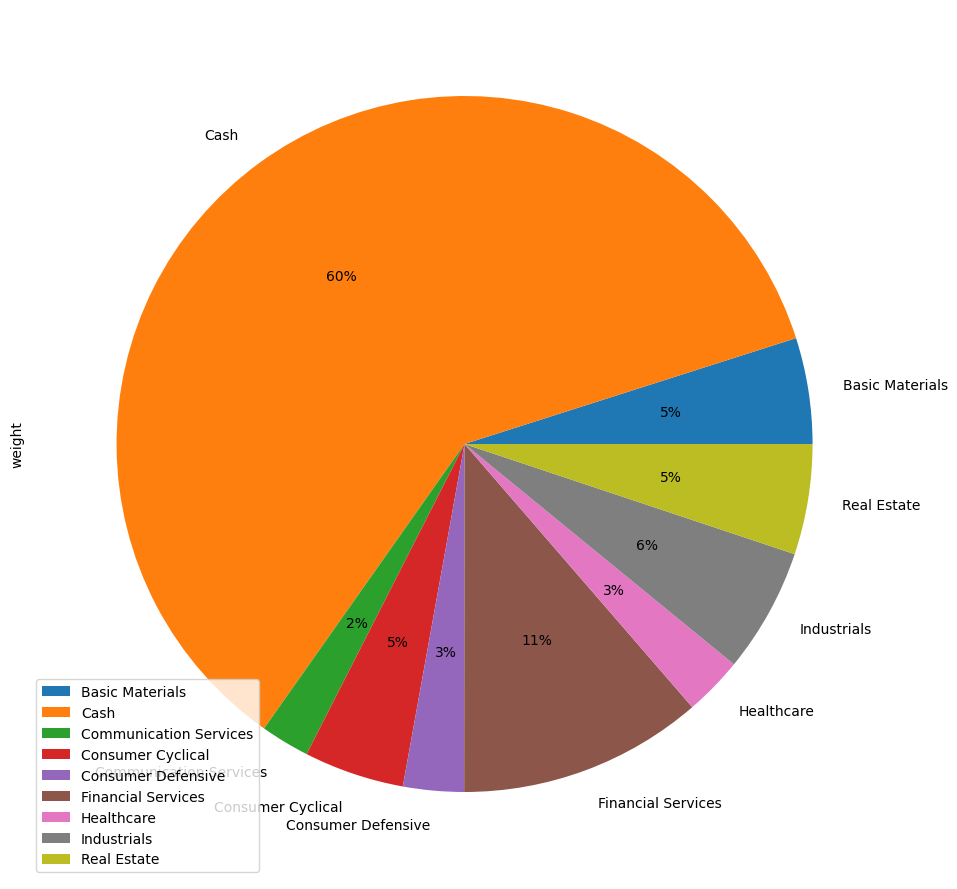

In [ ]:
new_dataset.groupby(['sector']).sum().plot(kind='pie', y='weight', autopct='%1.0f%%')

plt.tight_layout()

# We save the graph in jpg format
plt.savefig("my_graph.jpg")
plt.show()

In [ ]:

dataset = new_dataset
# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(dataset).mark_bar().encode(
  x='sum(weight)',
  y='sector',
  color='sector'
)

alt.Chart(...)

In [ ]:
RankingTable08092023 = pd.read_csv("/content/ranking_table130923.csv")
RankingTable08092023

,symbol,name,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
0,TRU.XJSE,TRUWORTHS INT LTD,TRU,3.684237,1.0,2023-09-13,7400.0,0.014953,43.410853,0.017039,36.049304,2667.648472,5971.70,3679.0,3808.027947,True,False
1,SDO.XJSE,STADIO HOLDINGS LIMITED,SDO,1.449046,2.0,2023-09-13,507.0,0.023255,12.666667,0.010957,338.335805,1715.362532,469.69,3679.0,3808.027947,True,False
2,ADH.XJSE,ADVTECH LTD,ADH,1.393662,3.0,2023-09-13,2080.0,0.014759,13.785558,0.017263,129.938155,2702.713618,1866.76,3679.0,3808.027947,True,False
3,KST.XJSE,PSG KONSULT LIMITED,KST,1.367644,4.0,2023-09-13,1335.0,0.013880,2.692308,0.018357,215.277002,2873.947982,NaN,3679.0,3808.027947,False,False
4,ABG.XJSE,ABSA GROUP LIMITED,ABG,1.278030,5.0,2023-09-13,17308.0,0.015736,3.951952,0.016191,14.645904,2534.913120,17188.86,3679.0,3808.027947,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,BAW.XJSE,BARLOWORLD LTD,BAW,0.074311,66.0,2023-09-13,8287.0,0.015535,-6.000454,0.016401,30.985297,2567.751556,8562.07,3679.0,3808.027947,False,False
66,SSK.XJSE,STEFANUTI STCK HLDGS LTD,SSK,0.066721,67.0,2023-09-13,127.0,0.036244,-2.307692,0.007030,866.633481,1100.624520,130.88,3679.0,3808.027947,False,False
67,IPF.XJSE,INVESTEC PROPERTY FUND LTD,IPF,0.064285,68.0,2023-09-13,745.0,0.009154,-13.972286,0.027836,584.958286,4357.939233,779.61,3679.0,3808.027947,False,False
68,DCP.XJSE,DIS-CHEM PHARMACIES LTD,DCP,0.062948,69.0,2023-09-13,2300.0,0.020443,-9.448819,0.012464,84.840648,1951.334897,2419.17,3679.0,3808.027947,False,False


In [ ]:
Portfolio = pd.read_csv("/content/portfolio130923.csv")
Portfolio

,Unnamed: 0,name,symbol,ticker,momentum_score,rank,date,close,20d_vol,close_90_roc,weight,units,ZAR,100d_sma,index,index_sma,trend,index_trend
0,SDO.JO,STADIO HOLDINGS LIMITED,SDO.XJSE,SDO,1.449046,2.0,2023-09-13,507.0,0.023255,12.666667,0.010957,336.293753,1705.009328,469.690000,3679.0,3808.027947,True,False
1,ADH.JO,ADVTECH LTD,ADH.XJSE,ADH,1.393662,3.0,2023-09-13,2080.0,0.014759,13.785558,0.017263,129.153903,2686.401180,1866.760000,3679.0,3808.027947,True,False
2,ABG.JO,ABSA GROUP LIMITED,ABG.XJSE,ABG,1.278030,5.0,2023-09-13,17308.0,0.015736,3.951952,0.016191,14.557508,2519.613456,17188.860000,3679.0,3808.027947,True,False
3,MTM.JO,MOMENTUM MET HLDGS LTD,MTM.XJSE,MTM,1.260827,6.0,2023-09-13,1982.0,0.016835,8.424508,0.015135,118.830230,2355.215149,1849.210000,3679.0,3808.027947,True,False
4,FFB.JO,FORTRESS REIT LTD B,FFB.XJSE,FFB,1.122735,8.0,2023-09-13,583.0,0.022675,5.807623,0.011237,299.928318,1748.582096,526.460000,3679.0,3808.027947,True,False
5,MPT.JO,MPACT LIMITED,MPT.XJSE,MPT,1.108973,9.0,2023-09-13,2949.0,0.017053,9.222222,0.014941,78.842887,2325.076745,2725.210000,3679.0,3808.027947,True,False
6,SPG.JO,SUPER GROUP LTD,SPG.XJSE,SPG,1.032155,10.0,2023-09-13,3269.0,0.014804,4.977521,0.017211,81.928981,2678.258381,3256.110000,3679.0,3808.027947,True,False
7,CLI.JO,CLIENTELE LTD,CLI.XJSE,CLI,0.882501,12.0,2023-09-13,1152.0,0.015984,9.714286,0.015941,215.332326,2480.628396,1097.440000,3679.0,3808.027947,True,False
8,MRF.JO,MERAFE RESOURCES LTD,MRF.XJSE,MRF,0.817270,14.0,2023-09-13,123.0,0.029605,3.361345,0.008607,1088.871792,1339.312304,120.700000,3679.0,3808.027947,True,False
9,RDF.JO,REDEFINE PROPERTIES LTD,RDF.XJSE,RDF,0.794332,15.0,2023-09-13,352.0,0.014250,-1.123596,0.017880,790.441719,2782.354850,345.450000,3679.0,3808.027947,True,False
